In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import open3d as o3d
from open3d import JVisualizer

In [2]:
project_dir = os.path.realpath('..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

from utils import invnormalize_imagenet
from datasets.habitat import HabitatDataset
from configs import get_cfg_defaults

In [3]:
opt = get_cfg_defaults()
opt.data_path = '/scratch/shantanu/HabitatGibson/data'
opt.bev_dir = '/scratch/shantanu/HabitatGibson/bevs/sim'
opt.batch_size = 1
opt.frame_ids = [0]

In [4]:
num_output_channels = 64  # Number of channels to divide the depth range (0.1-3.3m) into.
res = 0.05 # Resolution for the bev map (cell size)
x_min = -1.6
x_max = 1.6
z_min = 0.1
z_max = 3.3
bev_size = (64, 64)
cam_offset = torch.Tensor([x_min, 0, z_min]).float() # Position of bev bottom-left w.r.t camera origin.

# Corresponds to first and last channel in the depth predictions
min_depth = z_min + res/2
max_depth = min_depth + (res * num_output_channels) - res

In [5]:
split = '../splits/gibson/gibson_1img.txt'
with open(split, 'r') as f:
    filenames = f.read().splitlines()

In [6]:
load_keys = ['depth', 'bev', 'pose', 'ego_map_gt']

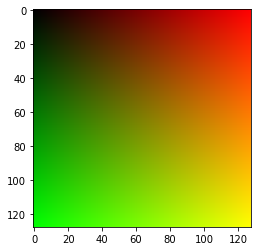

In [7]:
def set_pix_coords(opt):
    meshgrid = np.meshgrid(range(opt.width), range(opt.height), indexing='xy')
    id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
    id_coords = nn.Parameter(torch.from_numpy(id_coords), requires_grad=False)

    ones = nn.Parameter(torch.ones(1, 1, opt.height * opt.width), requires_grad=False)

    pix_coords = torch.unsqueeze(torch.stack([id_coords[0].view(-1), id_coords[1].view(-1)], 0), 0)
    pix_coords = nn.Parameter(torch.cat([pix_coords, ones], 1), requires_grad=False)
    return pix_coords

pix_coords = set_pix_coords(opt)
plt.imshow(pix_coords.squeeze().reshape(3, opt.height, opt.width).permute(1,2,0).cpu().detach().numpy()/127)

In [8]:
dataset = HabitatDataset(opt, filenames, is_train=True, load_keys=load_keys)

dataloader = DataLoader(dataset, opt.batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=True)

/home/shantanu.singh/miniconda3/envs/py37/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [9]:
inputs = next(iter(dataloader))

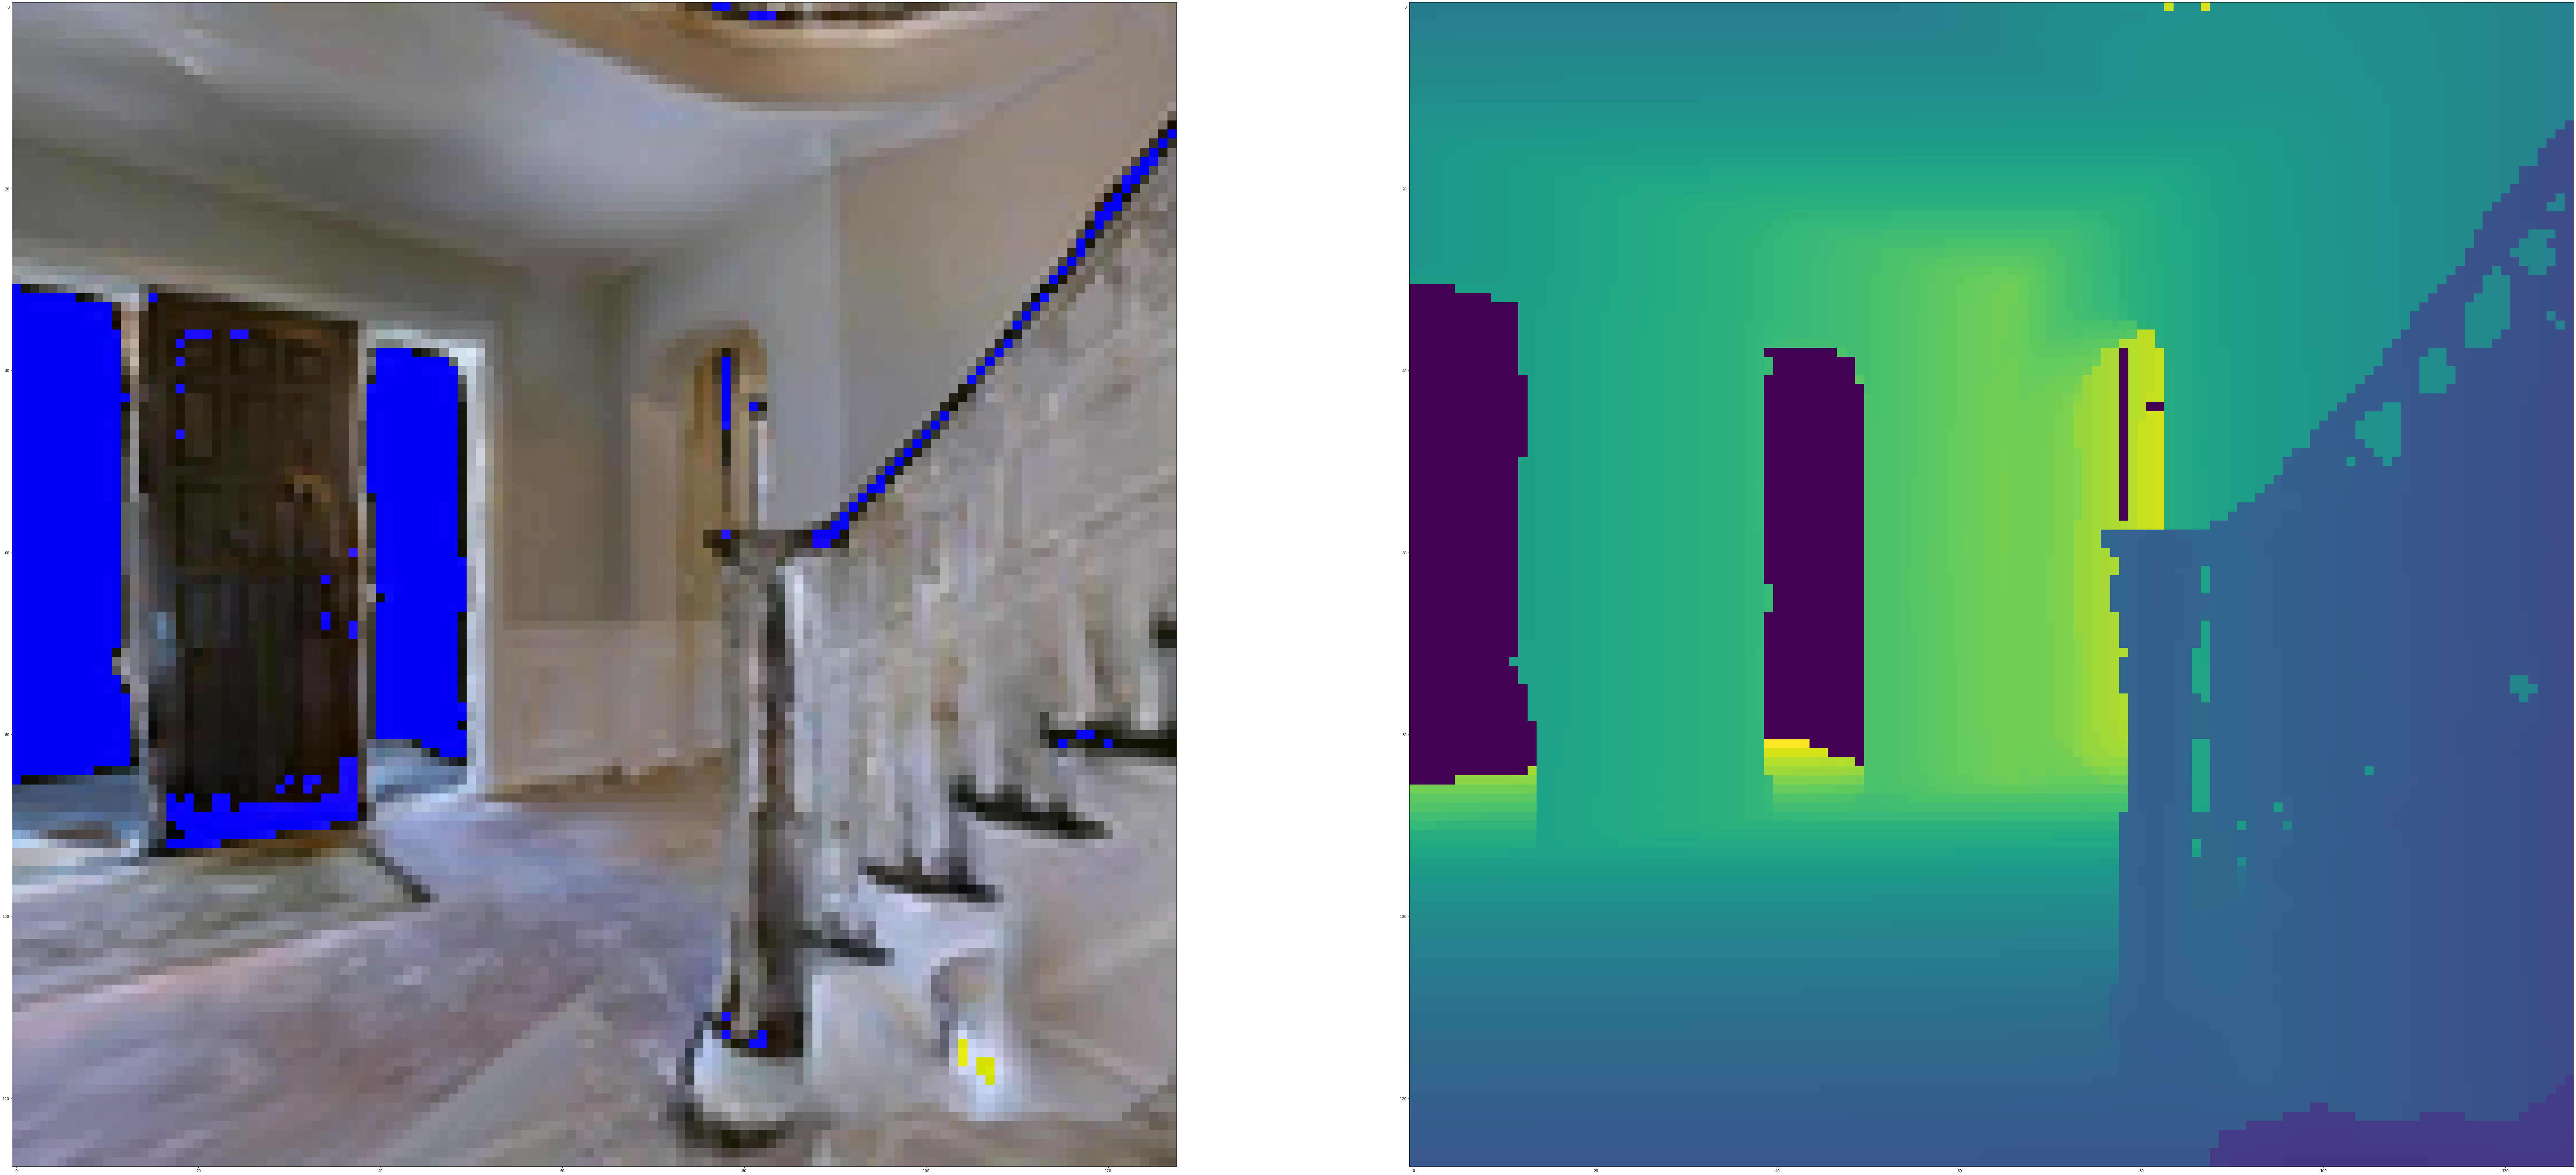

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(128, 64))

color = (invnormalize_imagenet(inputs[('color', 'l', 0)][0,0].cpu().detach()).numpy() * 255).astype(np.uint8).transpose(1,2,0)
depth = inputs[("depth_gt", "l")][0,0].cpu().detach().numpy()

ax[0].imshow(color)
ax[1].imshow(depth)

#### Ground Truth

In [11]:
gt_depth = inputs[("depth_gt", "l")].float()
gt_depth = gt_depth.reshape((-1, opt.height, opt.width))  # Flatten out the batch and timesteps dim

B, N, D = gt_depth.shape[0], opt.height * opt.width, num_output_channels

# Create point cloud using depth map and inv_K.

inv_K = inputs[('inv_K', 0)]
inv_K = inv_K.repeat(B//inv_K.shape[0], 1, 1)
cam_points = torch.matmul(inv_K[:, :3, :3], pix_coords.repeat(B, 1, 1))
cam_points = gt_depth.view(B,N,1) * cam_points.permute(0, 2, 1) # B x N x 3
cam_points = cam_points.reshape(-1, 3)

org_cam_points = cam_points.clone()

In [12]:
# Assumes batch size is 0 and frame_idx is [0]

points = cam_points.cpu().detach().numpy()
colors = invnormalize_imagenet(inputs[('color', 'l', 0)]).cpu().detach().reshape(B, 3, N).permute(0,2,1).reshape(-1, 3).numpy()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

# To flip y-axis to point upwards and z-axis to point backwards (for right hand rule)
T = np.eye(4)
T[1,1] = -1
T[2,2] = -1

pcd = pcd.transform(T)

visualizer = JVisualizer()
visualizer.add_geometry(pcd)

visualizer.show()

JVisualizer with 1 geometries

In [13]:
visualizer.close_all()
del pcd

In [14]:
* num_output_channels +# Setup mask to filter out points relevant to lifting bev to 
loss_mask = torch.zeros(B*N, device=gt_depth.device, dtype=torch.bool)
loss_idx = torch.arange(B*N, device=gt_depth.device, dtype=torch.long)

# Discretize the point coordinates to get voxel coordinates.
# First shift the points from camera frame to bev frame (bottom-left corner)
cam_points = ((cam_points - cam_offset.to(cam_points.device)) / res).long()

# Append the batch index of every point to the point's coordinates (x,y,z). Used later in code to fetch from bev.
batch_ix = torch.cat([torch.full([N, 1], bx, device=cam_points.device, dtype=torch.long) for bx in range(B)])
cam_points = torch.cat((cam_points, batch_ix), 1)

valid = (cam_points[:, 0] >= 0) & (cam_points[:, 0] < bev_size[1])\
    & (cam_points[:, 2] >= 0) & (cam_points[:, 2] < bev_size[0])\
    & (cam_points[:, 1] >= 0)
valid_idx = torch.arange(B*N).long()[valid]

# Filter points outside the bev.
cam_points = cam_points[valid]
loss_idx = loss_idx[valid]

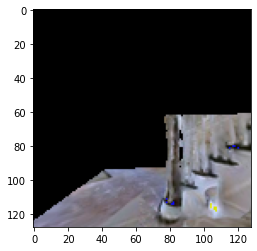

In [15]:
# Visualize the mask
mask = valid
mask = mask.reshape(B, opt.height, opt.width)[0].unsqueeze(dim=-1).repeat(1,1,3)
plt.imshow(mask * color)

In [16]:
# Rank the points so that points within the same cell in the bev are next to each other.
# The following would ensure points are arranged in ascending order of y-coordinate for each cell in the bev map.

max_y = z_max // res  # hfov = 90 degrees, vfov is lesser. So max_y will be at max this value.
ranks = cam_points[:, 1] + \
    (max_y * cam_points[:, 0]) + \
    (max_y * bev_size[1] * cam_points[:, 2]) + \
    (max_y * bev_size[1] * bev_size[0] * cam_points[:, 3])

sorts = ranks.argsort()

# Assign the bev cell id to points.
cell_ids = cam_points[:, 0] + \
    (bev_size[1] * cam_points[:, 2]) + \
    (bev_size[1] * bev_size[0] * cam_points[:, 3])

cell_ids = cell_ids[sorts]

# Now for each cell, pick the first item as it has the smallest y-coordinate, 
# which means it is the highest in its respective cell.

min_height_mask = torch.ones(cell_ids.shape[0], device=cell_ids.device, dtype=torch.bool)
min_height_mask[:-1] = (cell_ids[1:] != cell_ids[:-1])

# Now for these selected points across the bev grid, set the loss_mask to True.
# We only compute the loss for these points.
loss_idx = loss_idx[sorts]
loss_idx = loss_idx[min_height_mask]
loss_mask[loss_idx] = True
loss_mask = loss_mask.reshape(B, N)

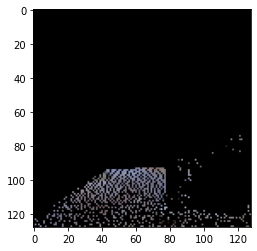

In [17]:
# Visualize the mask
mask = loss_mask.reshape(B, opt.height, opt.width)[0].unsqueeze(dim=-1).repeat(1,1,3)
plt.imshow(mask * color)

In [18]:
bev = inputs[('bev_gt', 'l')].reshape(-1) # Flattened from B x Hb x Wb

# Now, we create a variable to store the class (unknown, occ, free) value for each point.
B_lifted = torch.zeros(B*N, device=bev.device, dtype=torch.long)

# For the points selected above, we sample values from the bev map and assign it to the var B_lifted.
bev_vals = torch.gather(bev, 0, cell_ids)
B_lifted[valid_idx] = bev_vals 

B_lifted = B_lifted.reshape(B, N)

In [19]:
# Now we discretize the depth to belong to one of the possible number of channels.
depth_c = ((gt_depth - z_min) / res).type(torch.int64)
depth_c = torch.clamp(depth_c, 0, num_output_channels-1)

depth_c

tensor([[[45, 45, 45,  ..., 48, 47, 47],
         [46, 46, 46,  ..., 48, 47, 47],
         [47, 47, 47,  ..., 48, 47, 47],
         ...,
         [30, 30, 30,  ..., 17, 17, 17],
         [29, 29, 29,  ..., 17, 17, 17],
         [29, 29, 29,  ..., 16, 16, 16]]])

In [20]:
# To combine the depth and bev values into a set of (DxC) classes, 
# we use idx = c x D + d, where c - class idx, d - depth idx, D - num_depth_channels

tgt_combined = (B_lifted + 3 * depth_c.reshape(B, N)).long()
print(tgt_combined.unique())

tensor([  0,  50,  52,  53,  56,  59,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 116, 117, 119, 120, 122, 123, 125,
        126, 127, 128, 129, 130, 132, 133, 134, 135, 137, 138, 140, 141, 142,
        143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 155, 156, 158, 159,
        160, 161, 162, 163, 165, 166, 168, 169, 171, 173, 174, 176, 177, 179,
        180, 181, 182, 183, 184, 186, 187, 189, 190, 191])


### Prediction

In [21]:
# Setup vars to provide dimensions for use in later part of the code

gt_depth = inputs[("depth_gt", "l")].float()
gt_depth = gt_depth.reshape((-1, opt.height, opt.width))  # Flatten out the batch and timesteps dim

B, N, D = gt_depth.shape[0], opt.height * opt.width, num_output_channels

##### For our model, we will be predicting logits for both depth and bev map.

In [22]:
# For the depth prediction, we use softmax to obtain probabilities of every channel for each pixel in the image.
# But for the purpose of computing loss, we use log_softmax.

depth_logits = torch.FloatTensor(B, D, N).uniform_(-3, 3)
depth_logprobs = torch.log_softmax(depth_logits, dim=1) # B x D x N

# We repeat the depth channel probability 3 times to be able to multiply with prob of each class when sampling from bev.
depth_logprobs = depth_logprobs.permute(0,2,1).unsqueeze(dim=-1).repeat(1,1,1,3)  # B x N x D x 3

In [23]:
# we create a var depth_range to store actual values of depth per channel to project the pixels to world points.
depth_vals = torch.linspace(min_depth, max_depth, num_output_channels, requires_grad=False).view(1, -1, 1, 1).float()
depth_vals = depth_vals.repeat(B, 1, opt.height, opt.width)
depth_range = depth_vals.view(*depth_vals.shape[:2], -1).unsqueeze(dim=2) # B x D x 1 x N

In [24]:
# We project the image points to world points. 
# Every pixel has D number of points, one for every depth channel.

inv_K = inputs[("inv_K", 0)]
inv_K = inv_K.repeat(B//inv_K.shape[0], 1, 1)
cam_points = torch.matmul(inv_K[:, :3, :3], pix_coords.repeat(B, 1, 1))
cam_points = cam_points.unsqueeze(dim=1).repeat(1, num_output_channels, 1, 1) # B x D x 3 x N

cam_points = (depth_range * cam_points).permute(0, 3, 1, 2)  # B x N x D x 3

cam_points = cam_points.reshape(-1, 3)

cam_points = ((cam_points - cam_offset.to(cam_points.device)) / res).long()

# We add the batch idx to the position coords to use while fetching class probs from bev.
batch_ix = torch.cat([torch.full([N* D, 1], bx, device=cam_points.device, dtype=torch.long) for bx in range(B)])
cam_points = torch.cat((cam_points, batch_ix), 1)

In [25]:
# Filter out points outside the bev grid. 
valid = (cam_points[:, 0] >= 0) & (cam_points[:, 0] < bev_size[1])\
    & (cam_points[:, 2] >= 0) & (cam_points[:, 2] < bev_size[0])\
    & (cam_points[:, 1] >= 0)

valid_idx = torch.arange(B*N*D).long()[valid]

cam_points = cam_points[valid]

In [26]:
# The bev prediction is basically 2 channels. 0th - Occ/Non-Occ. 1st- Explored/Non-Explored
# We use sigmoid on these to obtain probabilities for each.

bev_logits = torch.FloatTensor(B, 2, *bev_size).uniform_(-3, 3)
bev_probs = torch.sigmoid(bev_logits)

In [27]:
eps = 1e-7
bev_probs = torch.clamp(bev_probs, eps, 1-eps) # To avoid zero prob values as they go -inf when taking log

bev_probs = bev_probs.permute(0,2,3,1) # B x Hb x Wb x 2

#We now convert these probs into probability for each class (unknown, occ, free)
class_probs = torch.zeros((B, *bev_size, 3), device=bev_probs.device, dtype=torch.float32)  # B x Hb x Wb x 3 [unknown, occ, free]
class_probs[..., 0] = 1 - bev_probs[..., 1]  # p(Unknown) = 1 - p(Explored)
class_probs[..., 1] = bev_probs[..., 1] * bev_probs[..., 0]  # p(Occ) = p(Explored)p(Occupied)
class_probs[..., 2] = bev_probs[..., 1] * (1 - bev_probs[..., 0])  # p(Free) = p(Explored)(1 - p(Occupied))

In [28]:
# We create a variable to store predicted class's log probs for all points(one for every depth channel) for each pixel in the image.
# By default set prob=0.33 for all.
pred_B_lifted = torch.cat([torch.full([B*N*D, 1], -1.0986, device=class_probs.device, dtype=torch.float32) for _ in range(3)], dim=-1)

class_probs = class_probs.permute(0, 3, 1, 2).reshape(-1) # Flatten class_probs from B x 3 x Hb x Wb

# Then we sample class log_probs from the bev prediction for each of the cam_points and assign it in this var.
for C in range(3):
    gather_indices = cam_points[:, 0] + \
        (bev_size[1] * cam_points[:, 2]) + \
        (bev_size[1] * bev_size[0] * C) + \
        (bev_size[1] * bev_size[0] * 3 * cam_points[:, 3]) 

    idx_probs = torch.gather(class_probs, 0, gather_indices)
    pred_B_lifted[valid_idx, C] = torch.log(idx_probs)  # Assign log probs

pred_B_lifted = pred_B_lifted.reshape((B, N, D, 3))

In [29]:
# Now we combine the logprob for depth and class for each point by simply adding them.
# This corresponds to multiplying the probabilities which is equivalent to the joint probability of that (depth,class) for that pixel.
# p(c,d) = p(c|d)p(d), where c is the class, d is the depth channel.
# log(p(c,d)) = log(p(c|d)) + log(p(d))

combined_logprobs = (pred_B_lifted + depth_logprobs).view(B, opt.height, opt.width, D, 3)
combined_logprobs.shape

torch.Size([1, 128, 128, 64, 3])

Pred: torch.Size([1, 192, 16384]), Target: torch.Size([1, 16384])

Loss value: tensor(0.4083)


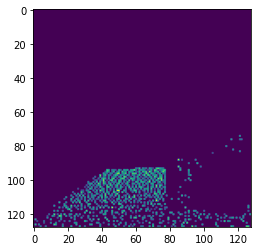

In [30]:
# We use the NLL loss to compute the loss for the prediction logprobs and the corresponding grouth truth classes.

combined_nll_loss = nn.NLLLoss(reduction='none')

combined_logprobs = combined_logprobs.reshape(B, N, D*3).permute(0,2,1)
print('Pred: {}, Target: {}\n'.format(combined_logprobs.shape, tgt_combined.shape))

combined_nll_loss = combined_nll_loss(combined_logprobs, tgt_combined)
combined_nll_loss *= loss_mask

plt.imshow(combined_nll_loss.reshape(B, opt.height, opt.width)[0])

print('Loss value:', combined_nll_loss.mean())